In [15]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

import datetime
import os, sys, glob
plt.style.use('dark_background')

In [16]:
labels = pd.read_csv('dataset/train_test_files/All_labels.txt', sep=" ", header=None)
labels.head()

,0,1
0,CF437.jpg,2.883333
1,AM1384.jpg,2.466667
2,AM1234.jpg,2.150000
3,AM1774.jpg,3.750000
4,CF215.jpg,3.033333


In [17]:
labels.describe()

,1
count,5500.000000
mean,2.990891
std,0.688112
min,1.016667
25%,2.500000
50%,2.833333
75%,3.533333
max,4.750000


In [18]:
labels_np = labels.values
print(labels_np[:5])

[['CF437.jpg' 2.8833330000000004]
 ['AM1384.jpg' 2.4666669999999997]
 ['AM1234.jpg' 2.15]
 ['AM1774.jpg' 3.75]
 ['CF215.jpg' 3.0333330000000003]]


In [19]:
imgs = np.empty((len(labels_np), 350, 350, 3), dtype=np.uint8)

for i, (img_filename, rating) in enumerate(labels_np):
    img = cv2.imread(os.path.join('./dataset/Images', img_filename))
    
    if img.shape[0] != 350 or img.shape[1] != 350:
        print(img_filename)
        
    imgs[i] = img

In [20]:
x_train, x_val, y_train, y_val = train_test_split(imgs, labels_np[:, 1], test_size=0.1)
np.save('np_data/x_train.npy', x_train)
np.save('np_data/x_val.npy', x_val)
np.save('np_data/y_train.npy', y_train)
np.save('np_data/y_val.npy', y_val)
print(x_train.shape, x_val.shape)
print(y_train.shape, y_val.shape)

(4950, 350, 350, 3) (550, 350, 350, 3)
(4950,) (550,)


In [22]:
# ValueError: Object arrays cannot be loaded when allow_pickle=False
# 에러시 아래 두 코드를 추가
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

x_train = np.load('np_data/x_train.npy')
y_train = np.load('np_data/y_train.npy')
x_val = np.load('np_data/x_val.npy')
y_val = np.load('np_data/y_val.npy')

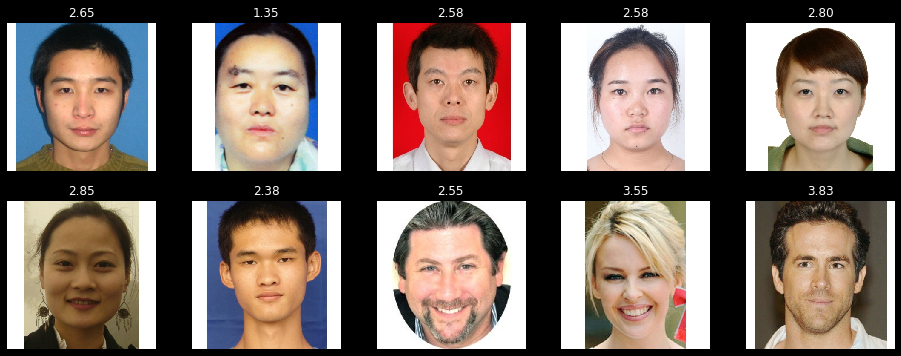

In [23]:
plt.figure(figsize=(16, 6))
for i, img in enumerate(x_train[:10]):
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.title('%.2f' % y_train[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [24]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow(
    x=x_train, y=y_train,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    x=x_val, y=y_val,
    batch_size=32,
    shuffle=False
)

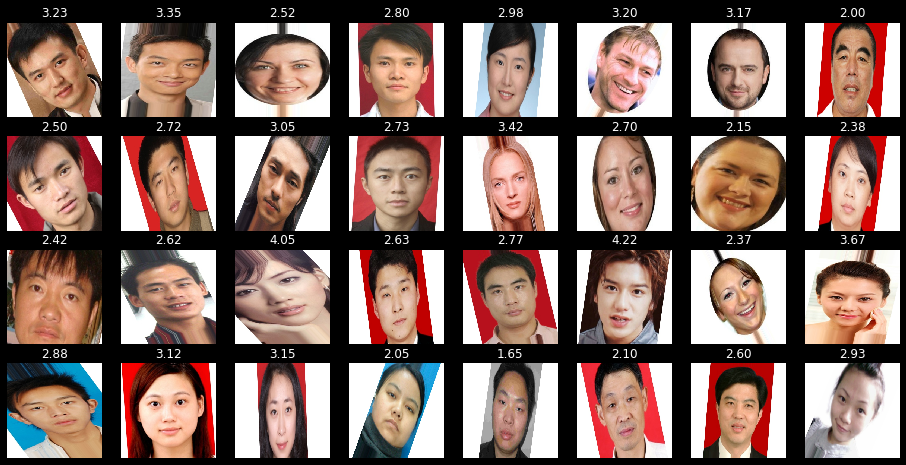

In [25]:
augs = train_generator.__getitem__(8)

plt.figure(figsize=(16, 8))
for i, img in enumerate(augs[0]):
    plt.subplot(4, 8, i+1)
    plt.title('%.2f' % augs[1][i])
    plt.axis('off')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img.squeeze())

In [26]:
len(train_generator)

155

## Model build

In [27]:
inputs = Input(shape=(350, 350, 3))

net = Conv2D(32, kernel_size=3, strides=1, padding='same')(inputs)
net = LeakyReLU()(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(32, kernel_size=3, strides=1, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(32, kernel_size=3, strides=1, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(32, kernel_size=3, strides=1, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(32, kernel_size=3, strides=1, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net)

net = Dense(256)(net)
net = Activation('relu')(net)
net = Dense(128)(net)
net = Activation('relu')(net)
net = Dense(1)(net)
outputs = Activation('linear')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='mae')

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 350, 350, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 350, 350, 32)      896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 350, 350, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 175, 175, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 175, 175, 32)      9248      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 175, 175, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 87, 87, 32)        0   

## Train model

In [29]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit_generator(
    train_generator, epochs=10, validation_data=val_generator,
    callbacks=[
        ModelCheckpoint('models/%s.h5' % (start_time), monitor='val_loss', save_best_only=True, mode='min', verbose=1)
    ]
)

Epoch 1/10
155/155 [==============================] - 569s 4s/step - loss: 0.5122 - val_loss: 0.3713

Epoch 00001: val_loss improved from inf to 0.37125, saving model to models/2020_04_20_18_15_48.h5
Epoch 2/10
155/155 [==============================] - 614s 4s/step - loss: 0.4631 - val_loss: 0.2643

Epoch 00002: val_loss improved from 0.37125 to 0.26430, saving model to models/2020_04_20_18_15_48.h5
Epoch 3/10
155/155 [==============================] - 695s 4s/step - loss: 0.4566 - val_loss: 0.2850

Epoch 00003: val_loss did not improve from 0.26430
Epoch 4/10
155/155 [==============================] - 646s 4s/step - loss: 0.4283 - val_loss: 0.3051

Epoch 00004: val_loss did not improve from 0.26430
Epoch 5/10
 90/155 [================>.............] - ETA: 4:19 - loss: 0.4280

KeyboardInterrupt: 

## Evaluate model

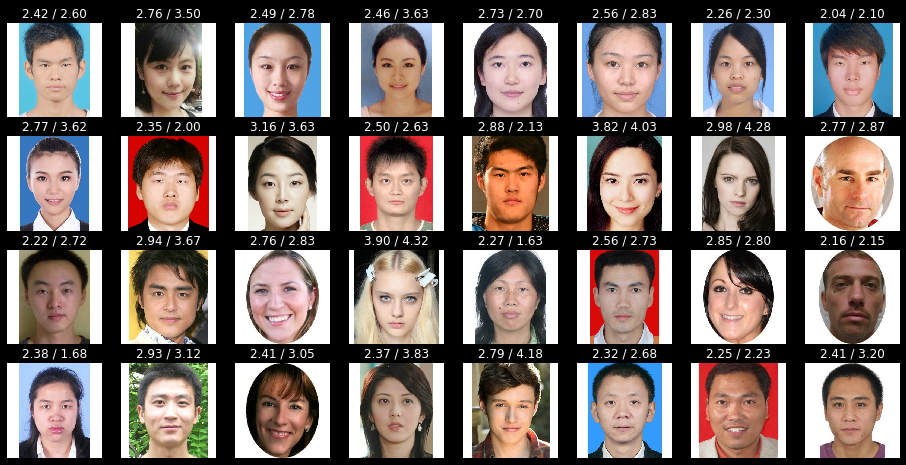

In [30]:
model = load_model('models/2020_04_20_18_15_48.h5')

val_data = val_generator.__getitem__(0)

preds = model.predict(val_data[0])

plt.figure(figsize=(16, 8))
for i, img in enumerate(val_data[0]):
    plt.subplot(4, 8, i+1)
    plt.title('%.2f / %.2f' % (preds[i], val_data[1][i]))
    plt.axis('off')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img.squeeze())

## Test model

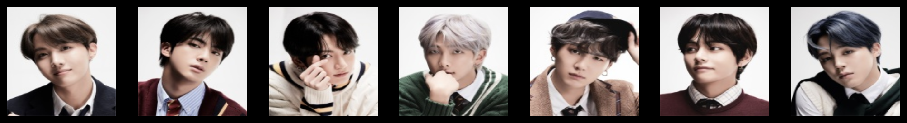

In [31]:
img_test_list = glob.glob('img/*.jpg')

imgs_test_resized = []

plt.figure(figsize=(16, 8))
for i, img_path in enumerate(img_test_list):
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, (350, 350))

    plt.subplot(1, len(img_test_list), i+1)
    plt.axis('off')
    img = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    plt.imshow(img.squeeze())
    
    img_resized = img_resized.astype(np.float32) / 255.
    imgs_test_resized.append(img_resized)

imgs_test_resized = np.array(imgs_test_resized, dtype=np.float32)

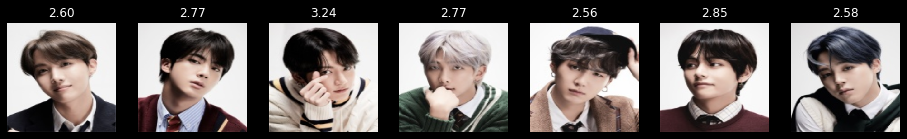

In [32]:
preds = model.predict(imgs_test_resized)

plt.figure(figsize=(16, 8))
for i, img in enumerate(imgs_test_resized):
    plt.subplot(1, len(imgs_test_resized), i+1)
    plt.title('%.2f' % (preds[i]))
    plt.axis('off')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img.squeeze())